In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [4]:
train_data_dir = "training_set/training_set"
test_data_dir = "test_set/test_set"

In [5]:
from torchvision import transforms as T

# data augmentation
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [6]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [7]:
import glob
from glob import glob
import cv2
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
id2int = {'dogs':1, 'cats':0}

In [9]:
from torch.utils.data import Dataset, DataLoader
class CatDogImages(Dataset):

    def __init__(self, folder, transform=None):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        from random import shuffle, seed
        seed(10)
        shuffle(self.fpaths)
        self.transform = transform

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        img = cv2.imread(f)
        clss = f.split('/')[-2]
        return img, clss

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(dt).to(device) for dt in [imgs, classes]]
        return imgs, classes, _imgs

Image of :
 dogs


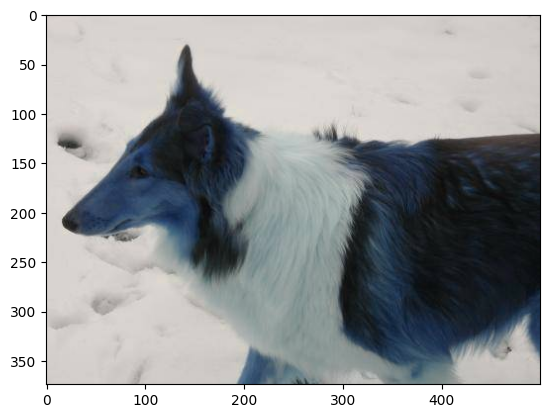

In [10]:
import matplotlib.pyplot as plt
dts = CatDogImages(train_data_dir)
im, lb = dts[5]
plt.imshow(im)
print('Image of :\n', lb)

In [11]:
trn_ds = CatDogImages(train_data_dir, transform=trn_tfms)
val_ds = CatDogImages(test_data_dir, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=True, collate_fn=val_ds.collate_fn)

In [12]:
import torch.nn as nn
n_classes = 2
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class CatDogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [13]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [14]:
from torch import optim
!pip install -U -q torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 45.6 MB/s eta 0

In [15]:
model = CatDogClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  val_acc: 0.501  trn_loss: 0.726  val_loss: 0.853  trn_acc: 0.545  (20.06s - 982.71s remaining)
EPOCH: 2.000  val_acc: 0.501  trn_loss: 0.646  val_loss: 1.323  trn_acc: 0.651  (32.60s - 782.50s remaining)
EPOCH: 3.000  val_acc: 0.505  trn_loss: 0.637  val_loss: 0.865  trn_acc: 0.652  (45.16s - 707.54s remaining)
EPOCH: 4.000  val_acc: 0.569  trn_loss: 0.583  val_loss: 0.820  trn_acc: 0.697  (57.85s - 665.24s remaining)
EPOCH: 5.000  val_acc: 0.524  trn_loss: 0.524  val_loss: 1.153  trn_acc: 0.741  (70.81s - 637.31s remaining)
EPOCH: 6.000  val_acc: 0.541  trn_loss: 0.552  val_loss: 1.194  trn_acc: 0.725  (83.62s - 613.24s remaining)
EPOCH: 7.000  val_acc: 0.566  trn_loss: 0.496  val_loss: 0.957  trn_acc: 0.754  (96.43s - 592.37s remaining)
EPOCH: 8.000  val_acc: 0.605  trn_loss: 0.485  val_loss: 0.810  trn_acc: 0.765  (108.97s - 572.11s remaining)
EPOCH: 9.000  val_acc: 0.538  trn_loss: 0.485  val_loss: 1.321  trn_acc: 0.765  (121.56s - 553.77s remaining)
EPOCH: 10.000  va

100%|██████████| 151/151 [00:00<00:00, 2178.26it/s]


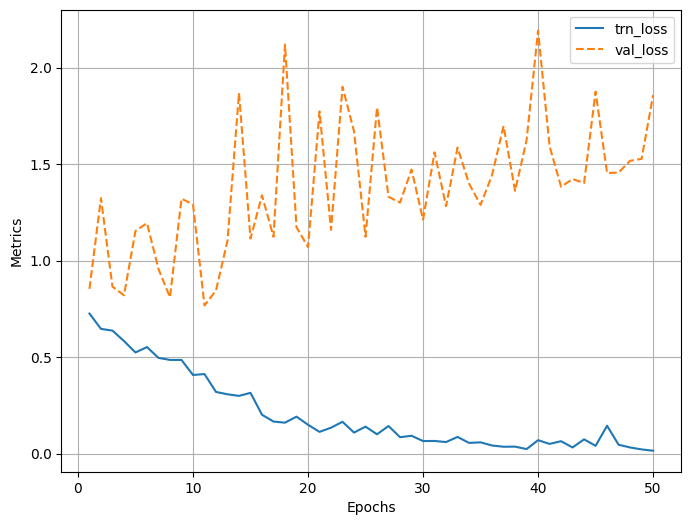

100%|██████████| 151/151 [00:00<00:00, 2000.63it/s]


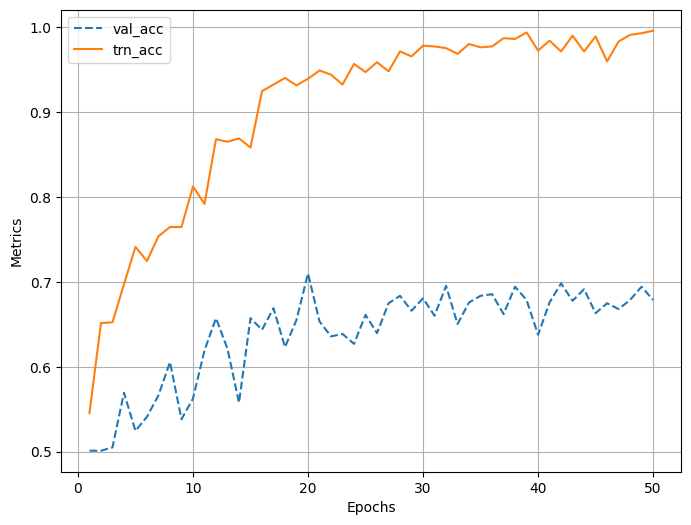

In [17]:
log.plot_epochs('_loss')
log.plot_epochs('_acc')

In [46]:
# Fetch the convolutional layer in the fifth conv block
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [47]:
# Function that takes an input image and fetch the heatmap coresponding to the activations
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    pred = logits.max(-1)[-1]
    heatmaps = []
    activations = im2fmap(x)

    # get the model's prediction
    model.zero_grad()
    # compute gradients of the model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'dogs' if pred.item() else 'cats'

In [56]:
# Function to upsample the heatmap to the shape the image
SZ = 300
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

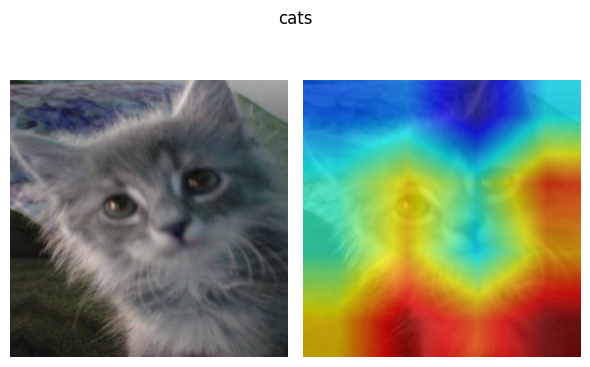

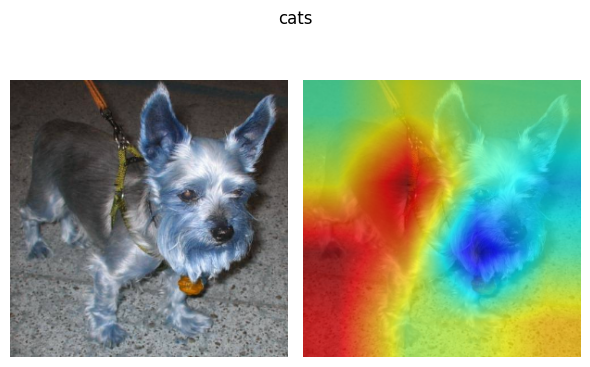

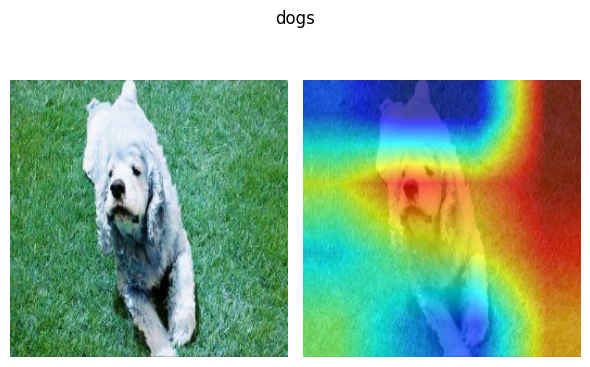

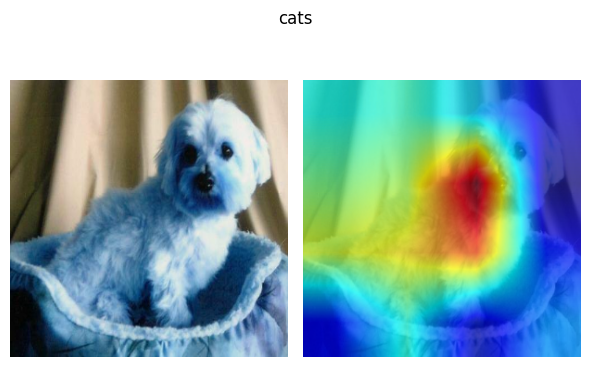

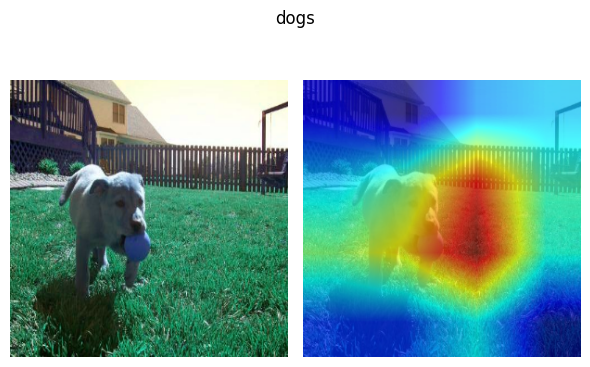

In [58]:
N = 5
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    # Notice how the cats are idetified
    # if(pred=='dogs'):
        # continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(6,4), suptitle=pred)